In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

pygame 2.5.0 (SDL 2.28.0, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


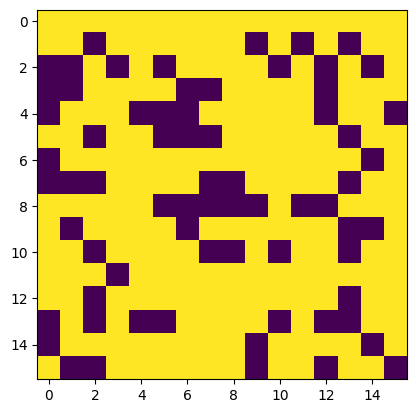

In [831]:
map = torch.rand(16, 16)<0.7
map[0] = True
plt.imshow(map.numpy())

In [832]:
class GridEnv(gym.Env):
    def __init__(self, map, n_envs, death=False, device=None):
        super().__init__()
        self.map, self.n_envs, self.death, self.device = map.to(device), n_envs, death, device
        self._actions = torch.tensor([[0, 0], [1, 0], [0, 1], [-1, 0], [0, -1]], dtype=torch.long, device=self.device)
        self.single_action_space = gym.spaces.Discrete(len(self._actions))
        self.action_space = gym.spaces.MultiDiscrete([len(self._actions) for _ in range(self.n_envs)])

    def _construct_obs(self, map, pos):
        n_envs = len(pos)
        obs = map.repeat(n_envs, 1, 1).to(torch.float32) - 1.
        obs[torch.arange(n_envs), pos[:, 0], pos[:, 1]] = 1.
        return obs[:, None, :, :], info
        
    def reset(self, *args, **kwargs):
        super().reset(*args, **kwargs)
        self.pos = torch.zeros(self.n_envs, 2, dtype=torch.long, device=self.device)
        obs, info = self._construct_obs(self.map, self.pos)
        return obs, info
        
    def step(self, action):
        if isinstance(action, (list, np.ndarray)):
            action = torch.as_tensor(action).to(self.device)
        action = self._actions[action]
        newpos = self.pos+action
        newpos = newpos.clamp(0, len(self.map))
        rew = torch.zeros(self.n_envs, device=self.device)
        term, trunc = torch.zeros(self.n_envs, dtype=bool, device=self.device), torch.zeros(self.n_envs, dtype=bool, device=self.device)
        lava = ~self.map[newpos[:, 0], newpos[:, 1]]
        if self.death:
            self.pos = torch.where(lava[:, None], torch.zeros_like(self.pos), newpos)
            term[lava] = True
        else:
            self.pos = torch.where(lava[:, None], self.pos, newpos)
        obs, info = self._construct_obs(self.map, self.pos)
        return obs, rew, term, trunc, info
                
    def all_possible_obs(self, flat=False):
        y, x = torch.arange(len(self.map), device=self.device), torch.arange(len(self.map), device=self.device)
        y, x = torch.meshgrid(y, x, indexing='ij')
        pos = torch.stack([y, x], dim=-1)
        pos = pos.reshape(-1, 2)
        obs, info = self._construct_obs(self.map, pos)
        if flat:
            return obs.reshape(-1, 1, len(self.map), len(self.map))
        else:
            return obs.reshape(len(self.map), len(self.map), 1, len(self.map), len(self.map))

env = GridEnv(map, 128, death=True)
obs, info = env.reset()
obs, rew, term, trunc, info = env.step([2])

In [833]:
obs.shape

torch.Size([128, 1, 16, 16])

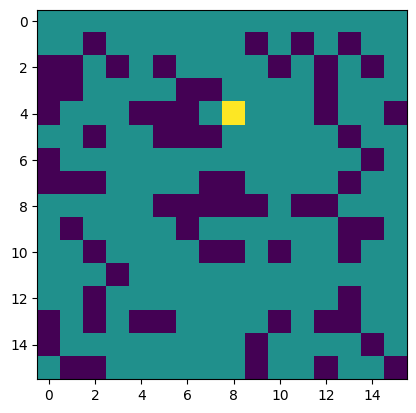

In [834]:
plt.imshow(env.all_possible_obs()[4,8, 0].numpy())

In [835]:
def plot_basis_rewmaps(env, net, goal_sample='eye', vmin=None, vmax=None):
    with torch.no_grad():
        latent = net(env.all_possible_obs(flat=True))
        print(latent.shape)
    if goal_sample=='eye':
        goal = torch.eye(net.latent_dim)[:16]
    elif goal_sample=='latent':
        goal = latent[torch.randperm(len(latent))[:16]]
    elif goal_sample=='randn':
        goal = torch.randn(16, net.latent_dim)
        goal = goal/goal.norm(dim=-1, keepdim=True)
    # print(goal.shape, latent.shape)
    rewmap = (goal@latent.T).reshape(-1, len(env.map), len(env.map))
    # print(rewmap.shape)
    plt.figure(figsize=(10, 10))
    for i in range(len(goal)):
        plt.subplot(int(np.sqrt(len(goal))), int(np.sqrt(len(goal))), i+1)
        plt.imshow(rewmap[i].numpy(), vmin=vmin, vmax=vmax)
        plt.colorbar()
    plt.tight_layout()

In [836]:
def calc_rewmap(env, net, goal_sample='eye', n_goals=16):
    with torch.no_grad():
        latent = net(env.all_possible_obs(flat=True))
        # print(latent.shape)
    if goal_sample=='eye':
        goal = torch.eye(n_goals, net.latent_dim)
    elif goal_sample=='latent':
        goal = latent[torch.randint(low=0, high=len(latent), size=(n_goals,))]
    elif goal_sample=='randn':
        goal = torch.randn(n_goals, net.latent_dim)
        goal = goal/goal.norm(dim=-1, keepdim=True)
    rewmap = (goal@latent.T)
    rewmap = rearrange(rewmap, 'b (h w) -> b h w', h=len(env.map))
    return rewmap

In [856]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer
    
class Net(nn.Module):
    def __init__(self, latent_dim=4, normalize=True):
        super().__init__()
        self.latent_dim = latent_dim
        self.normalize = normalize
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(1, 16, 3, padding=1, stride=1)),
            nn.LeakyReLU(),
            layer_init(nn.Conv2d(16, 32, 3, padding=1, stride=2)),
            nn.LeakyReLU(),
            layer_init(nn.Conv2d(32, 32, 3, padding=1, stride=1)),
            nn.LeakyReLU(),
            layer_init(nn.Conv2d(32, 32, 3, padding=1, stride=2)),
            nn.LeakyReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(512, latent_dim)),
        )
    def forward(self, x):
        x = self.network(x)
        if self.normalize:
            x = x/x.norm(p=2, dim=-1, keepdim=True)
        return x

net = Net(latent_dim=16)
obs, info = env.reset()
net(obs).shape

torch.Size([128, 16])

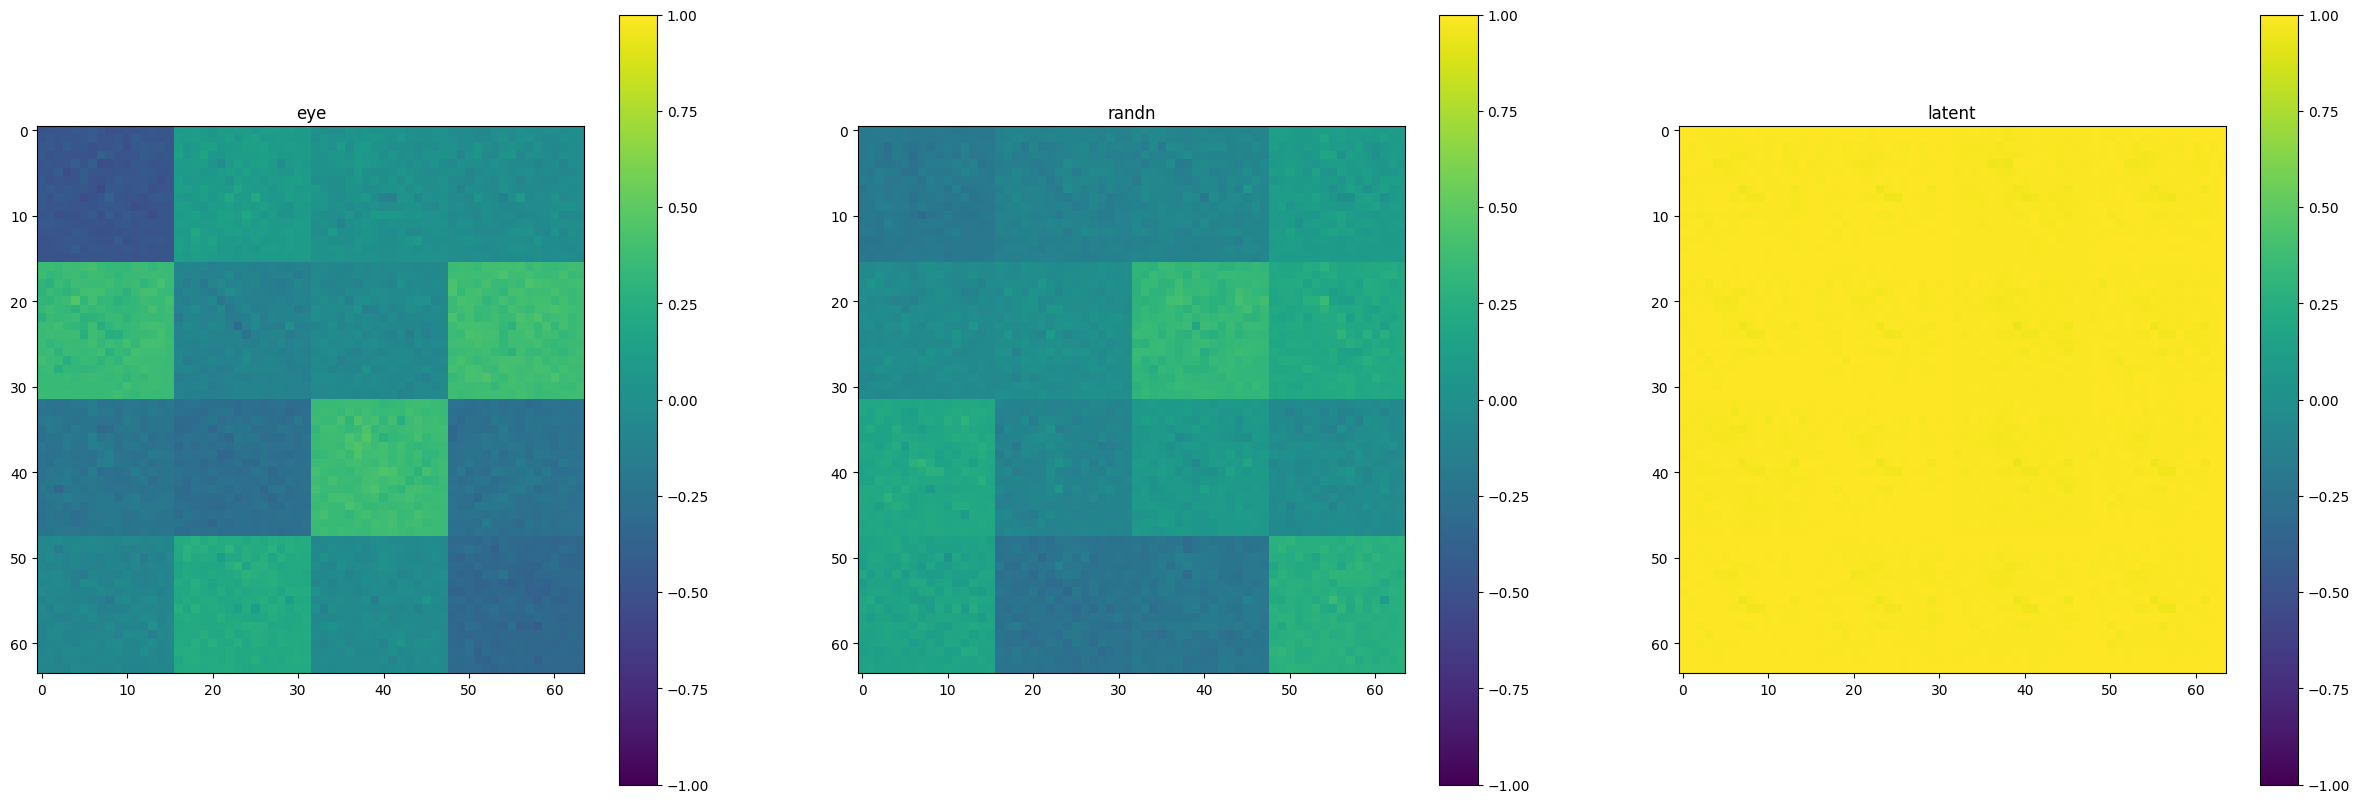

In [857]:
plt.figure(figsize=(30, 10))
for i, goal_sample in enumerate(['eye', 'randn', 'latent']):
    plt.subplot(1, 3, i+1)
    plt.title(goal_sample)
    plt.imshow(rearrange(calc_rewmap(env, net, goal_sample=goal_sample, n_goals=16), '(H W) h w -> (H h) (W w)', H=4), vmin=-1., vmax=1.)
    plt.colorbar()

In [858]:
opt = torch.optim.Adam(net.parameters(), lr=1e-4)

def lalign(x, y, alpha=2):
    return (x - y).norm(dim=1).pow(alpha).mean()
def lunif(x, t=2):
    sq_pdist = torch.pdist(x, p=2).pow(2)
    return sq_pdist.mul(-t).exp().mean().log()
    
obs_all = env.all_possible_obs(flat=True)
for i in range(1000):
    latent = net(obs_all)
    a = latent.reshape(len(env.map), len(env.map), -1)
    if np.random.rand()<0.5:
        x, y = a[:-1, :].flatten(0, 1), a[1:, :].flatten(0, 1)
    else:
        x, y = a[:, :-1].flatten(0, 1), a[:, 1:].flatten(0, 1)
    loss1 = lalign(x, y)
    loss2 = (lunif(x) + lunif(y)) / 2
    loss = 1.*loss1 + 1.0 *loss2
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    if i%30==0:
        print(f'{i=}, {loss.item()}, {loss1.item()}, {loss2.item()}')

i=0, -0.028830494731664658, 0.023027893155813217, -0.051858387887477875
i=30, -1.774430751800537, 1.5094523429870605, -3.2838830947875977
i=60, -2.0028305053710938, 1.461689829826355, -3.4645204544067383
i=90, -2.0984840393066406, 1.3477836847305298, -3.44626784324646
i=120, -2.216419219970703, 1.2213977575302124, -3.437817096710205
i=150, -2.272482395172119, 1.1443575620651245, -3.416840076446533
i=180, -2.3509435653686523, 1.0534387826919556, -3.4043824672698975
i=210, -2.4138991832733154, 0.9913603663444519, -3.405259609222412
i=240, -2.473681926727295, 0.9289133548736572, -3.402595281600952
i=270, -2.5100889205932617, 0.885202944278717, -3.395291805267334
i=300, -2.5354063510894775, 0.8533170819282532, -3.388723373413086
i=330, -2.568110227584839, 0.8125836849212646, -3.3806939125061035
i=360, -2.6303768157958984, 0.7510778903961182, -3.3814547061920166
i=390, -2.628237247467041, 0.7491708993911743, -3.377408027648926
i=420, -2.684325695037842, 0.6909875273704529, -3.37531328201293

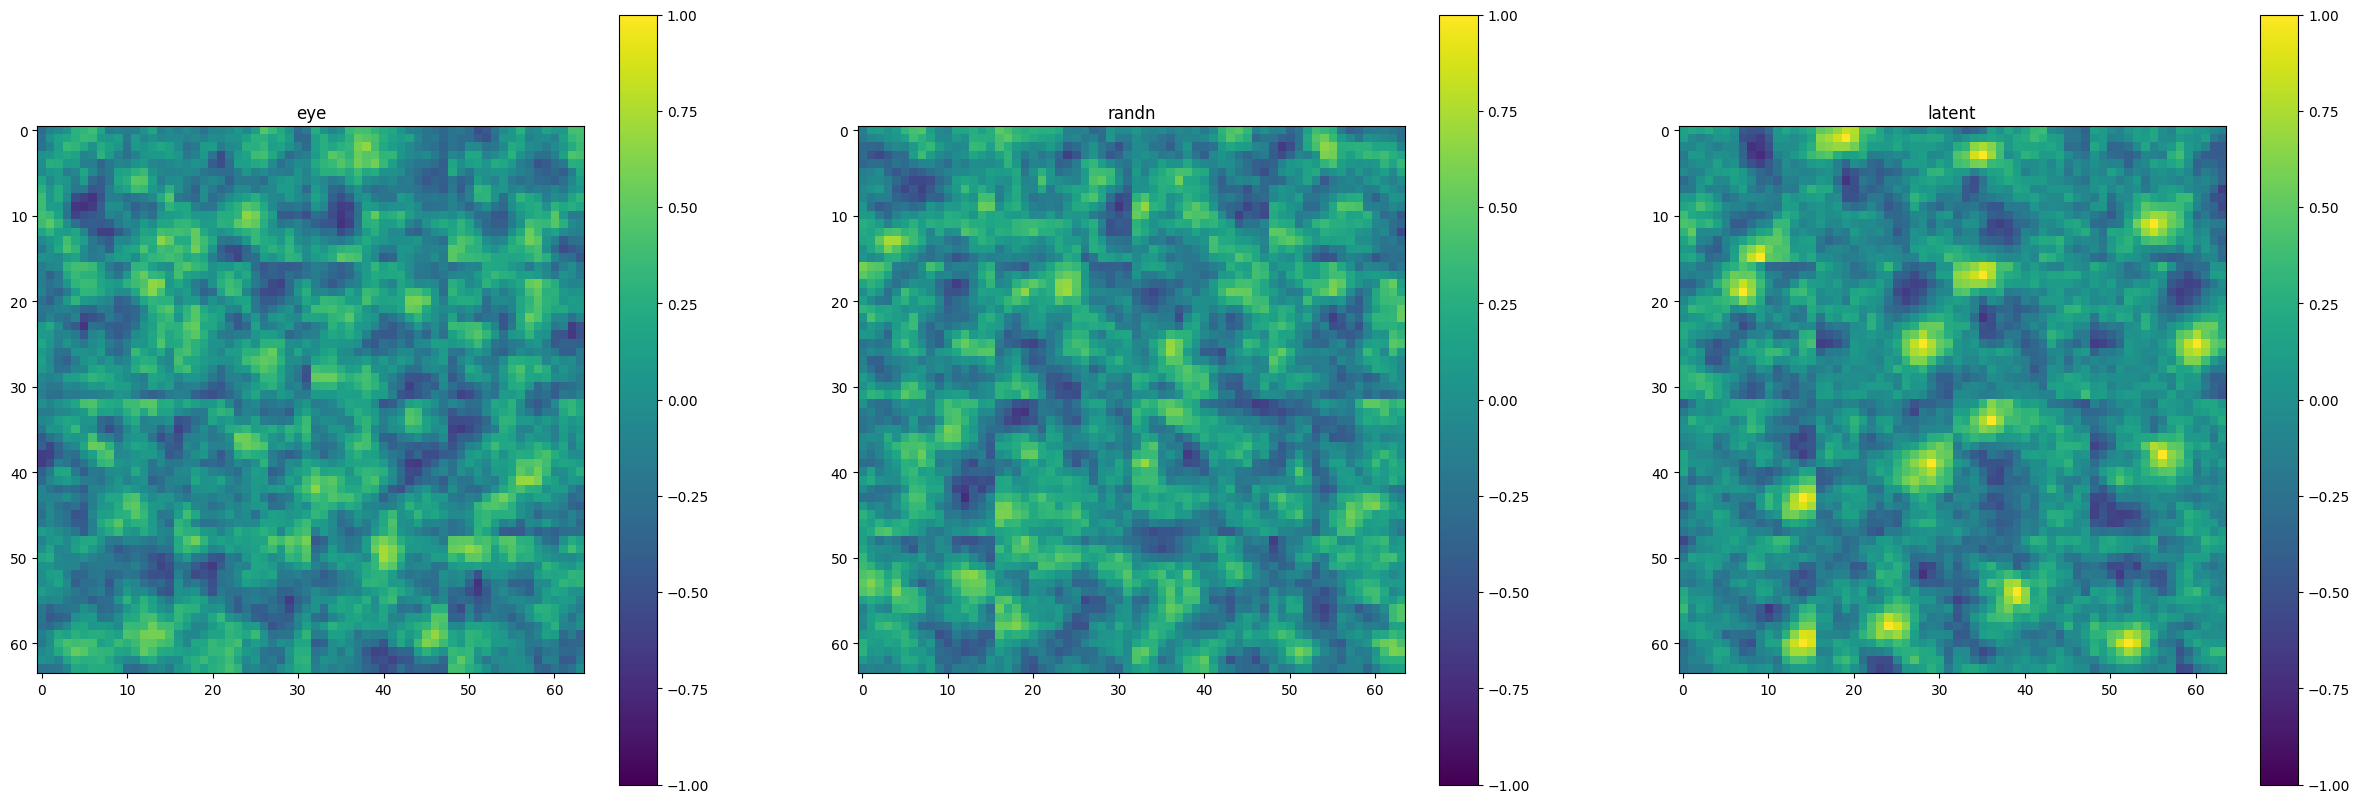

In [859]:
plt.figure(figsize=(30, 10))
for i, goal_sample in enumerate(['eye', 'randn', 'latent']):
    plt.subplot(1, 3, i+1)
    plt.title(goal_sample)
    plt.imshow(rearrange(calc_rewmap(env, net, goal_sample=goal_sample, n_goals=16), '(H W) h w -> (H h) (W w)', H=4), vmin=-1., vmax=1.)
    plt.colorbar()

In [860]:
latent.shape

torch.Size([256, 16])

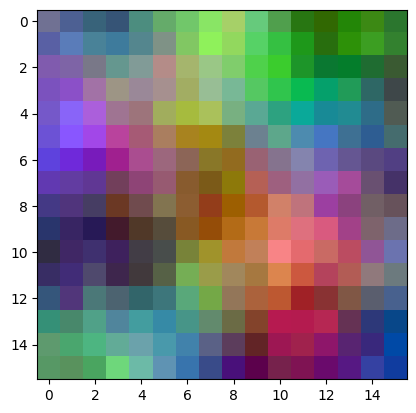

In [861]:
a = PCA(3).fit_transform(latent.detach().numpy())
a = (a-a.min())/(a.max()-a.min())
plt.imshow(a.reshape(16, 16, 3))

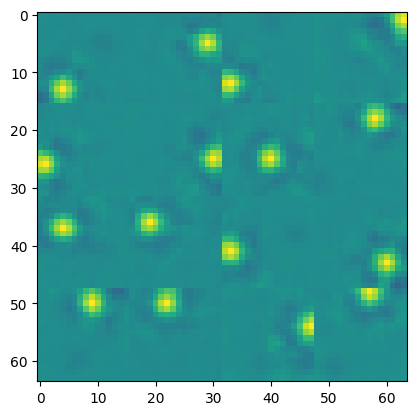

In [818]:
def temp(env, net, eps=0.0, n_goals=16):
    with torch.no_grad():
        latent = net(env.all_possible_obs(flat=True))        
    goal1 = latent[torch.randint(low=0, high=len(latent), size=(n_goals,))]
    goal2 = latent[torch.randint(low=0, high=len(latent), size=(n_goals,))]
    # goal = (goal1+goal2)/2.
    goal = goal2+(goal2-goal1)/10.
    # goal = goal+1e-1*torch.randn_like(goal)
    goal = goal/goal.norm(dim=-1, keepdim=True)
    rewmap = (goal@latent.T)
    rewmap = rearrange(rewmap, 'b (h w) -> b h w', h=len(env.map))
    return rewmap

plt.imshow(rearrange(temp(env, net, eps=0., n_goals=16), '(H W) h w -> (H h) (W w)', H=4), vmin=-1., vmax=1.)

In [503]:
obs = env.all_possible_obs()

In [504]:
obs.shape

torch.Size([16, 16, 1, 16, 16])